In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# SAM 3 Agent

This notebook shows an example of how an MLLM can use SAM 3 as a tool, i.e., "SAM 3 Agent", to segment more complex text queries such as "the leftmost child wearing blue vest".

## Env Setup

First install `sam3` in your environment using the [installation instructions](https://github.com/facebookresearch/sam3?tab=readme-ov-file#installation) in the repository.

In [2]:
import torch
# turn on tfloat32 for Ampere GPUs
# https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# use bfloat16 for the entire notebook. If your card doesn't support it, try float16 instead
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()

# inference mode for the whole notebook. Disable if you need gradients
torch.inference_mode().__enter__()

In [3]:
import os

SAM3_ROOT = os.path.dirname(os.getcwd())
os.chdir(SAM3_ROOT)

# setup GPU to use -  A single GPU is good with the purpose of this demo
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
_ = os.system("nvidia-smi")

## Build SAM3 Model

In [4]:
import sam3
from sam3 import build_sam3_image_model
from sam3.model.sam3_image_processor import Sam3Processor

sam3_root = os.path.join(os.path.dirname(sam3.__file__), "..")
bpe_path = f"{sam3_root}/assets/bpe_simple_vocab_16e6.txt.gz"
model = build_sam3_image_model(bpe_path=bpe_path)
processor = Sam3Processor(model, confidence_threshold=0.5)

## LLM Setup

Config which MLLM to use, it can either be a model served by vLLM that you launch from your own machine or a model is served via external API. If you want to using a vLLM model, we also provided insturctions below.

In [ ]:
'''
LLM_CONFIGS = {
    # vLLM-served models
    "qwen3_vl_8b_thinking": {
        "provider": "vllm",
        "model": "Qwen/Qwen3-VL-8B-Thinking",
    }, 
    # models served via external APIs
    # add your own
}

model = "qwen3_vl_8b_thinking"
LLM_API_KEY = "DUMMY_API_KEY"

llm_config = LLM_CONFIGS[model]
llm_config["api_key"] = LLM_API_KEY
llm_config["name"] = model

# setup API endpoint
if llm_config["provider"] == "vllm":
    LLM_SERVER_URL = "http://0.0.0.0:8001/v1"  # replace this with your vLLM server address as needed
else:
    LLM_SERVER_URL = llm_config["base_url"]
'''

LLM_CONFIGS = {
    # LM Studio-served models (OpenAI-compatible)
    "qwen3_vl_8b_thinking": {
        "provider": "lmstudio",                 # 标注一下来源，供你程序里区分
        "model": "qwen3-vl-8b-thinking",        # LM Studio /v1/models 返回的模型名
        "base_url": "http://192.168.1.218:1234/v1"  # LM Studio 的地址（带 /v1）
    },
    # 这里可以继续添加其他外部 API 模型
}

model = "qwen3_vl_8b_thinking"
LLM_API_KEY = "lm-studio"  # LM Studio 接受任意非空字符串

llm_config = LLM_CONFIGS[model]
llm_config["api_key"] = LLM_API_KEY
llm_config["name"] = model

# setup API endpoint
if llm_config.get("provider") == "vllm":
    LLM_SERVER_URL = "http://0.0.0.0:8001/v1"  # 如果将来切回 vLLM，可用这个分支
else:
    # LM Studio 或其他外部 API 使用各自的 base_url
    LLM_SERVER_URL = llm_config["base_url"]

# 你后续的请求应当指向：
# - GET  f"{LLM_SERVER_URL}/models"
# - POST f"{LLM_SERVER_URL}/chat/completions"
# - POST f"{LLM_SERVER_URL}/embeddings" （若需要）
# 并在 headers 里带上：
#   Authorization: Bearer {llm_config['api_key']}
#   Content-Type: application/json

### Setup vLLM server 
This step is only required if you are using a model served by vLLM, skip this step if you are calling LLM using an API like Gemini and GPT.

* Install vLLM (in a separate conda env from SAM 3 to avoid dependency conflicts).
  ```bash
    conda create -n vllm python=3.12
    pip install vllm --extra-index-url https://download.pytorch.org/whl/cu128
  ```
* Start vLLM server on the same machine of this notebook
  ```bash
    # qwen 3 VL 8B thinking
    vllm serve Qwen/Qwen3-VL-8B-Thinking --tensor-parallel-size 4 --allowed-local-media-path / --enforce-eager --port 8001
  ```

## Run SAM3 Agent Inference

In [16]:
from functools import partial
from IPython.display import display, Image
from sam3.agent.client_llm import send_generate_request as send_generate_request_orig
from sam3.agent.client_sam3 import call_sam_service as call_sam_service_orig
from sam3.agent.inference import run_single_image_inference

In [13]:
# prepare input args and run single image inference
image = "assets/images/test_image.jpg"
prompt = "the leftmost child wearing blue vest"
image = os.path.abspath(image)
send_generate_request = partial(send_generate_request_orig, server_url=LLM_SERVER_URL, model=llm_config["model"], api_key=llm_config["api_key"])
call_sam_service = partial(call_sam_service_orig, sam3_processor=processor)
output_image_path = run_single_image_inference(
    image, prompt, llm_config, send_generate_request, call_sam_service, 
    debug=True, output_dir="agent_output"
)

# display output
if output_image_path is not None:
    display(Image(filename=output_image_path))

Output JSON agent_output\test_image_the_leftmost_child_wearing_blue_vest_agent_qwen3_vl_8b_thinking_pred.json already exists. Skipping.


🚀 Starting speed test with model: qwen_vl_small_test...
------------------------------ Starting SAM 3 Agent Session... ------------------------------ 
> Text prompt: the leftmost child wearing blue vest
> Image path: c:\Users\Lloyd\sam3\sam3\..\assets\images\test_image.jpg



------------------------------ Round 1------------------------------



image_path c:\Users\Lloyd\sam3\sam3\..\assets\images\test_image.jpg
🔍 Calling model qwen3-vl-8b-thinking@q8_0...

>>> MLLM Response [start]
<think>
State that there is only one image in the message history (the raw input image). Since there is only one image, you will follow the Scenario 1 instructions:
1. Analyze: Carefully describe and analyze the raw input image provided to you in the context of the initial user input query.
2. Think: Based on your understanding of the image and the previously stated rules for how you should understand the initial user input query, think about precisely what target object(s) need to be grounded to accuratel

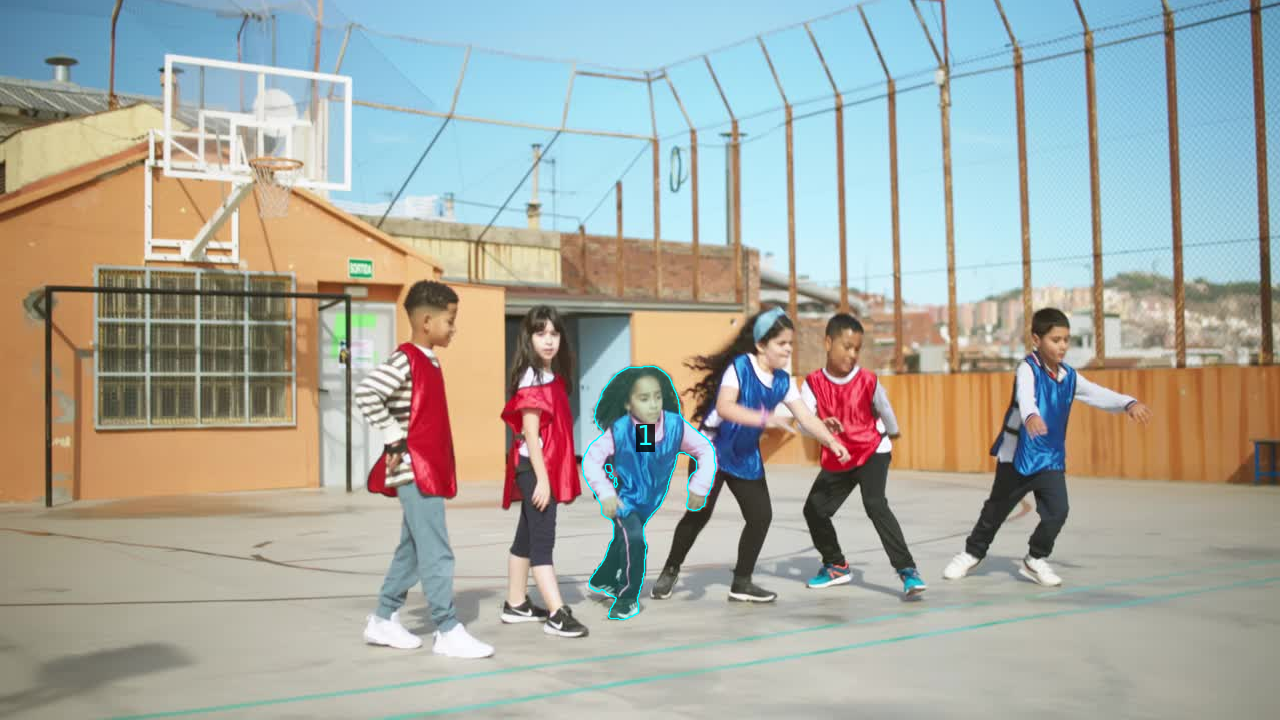

: 

In [ ]:
# use smaller qwen vl model to test the inference speed
# test 2
import time
import os

# Define a test config for the small model
# 注意：这里的 model 必须和 LM Studio 右侧边栏显示的 "Model Identifier" 完全一致
test_config = {
    "provider": "lmstudio",
    "model": "qwen3-vl-8b-thinking@q8_0",  # <--- 这里修改为你截图里的 ID
    "base_url": "http://192.168.1.218:1234/v1",
    "api_key": "lm-studio",
    "name": "qwen_vl_small_test"
}

# Construct absolute path to image to avoid FileExistsError
sam3_root = os.path.join(os.path.dirname(sam3.__file__), "..")
image = os.path.join(sam3_root, "assets", "images", "test_image.jpg")
prompt = "the leftmost child wearing blue vest"

print(f"🚀 Starting speed test with model: {test_config['name']}...")
start_time = time.time()

# Use the test_config for this specific call
send_generate_request = partial(send_generate_request_orig, server_url=test_config["base_url"], model=test_config["model"], api_key=test_config["api_key"])
call_sam_service = partial(call_sam_service_orig, sam3_processor=processor)

try:
    output_image_path = run_single_image_inference(
        image, prompt, test_config, send_generate_request, call_sam_service, 
        debug=True, output_dir="agent_output"
    )
    
    end_time = time.time()
    duration = end_time - start_time
    print(f"✅ Inference completed in {duration:.2f} seconds.")

    # display output
    if output_image_path is not None:
        display(Image(filename=output_image_path))
except Exception as e:
    print(f"❌ Error during inference: {e}")